In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import itertools
import datetime
import copy
import sys  
import os
import glob

sys.path.insert(0, '../')

from soundings.deep_learning import mlutilities as ml
from soundings.deep_learning import tf_neuralnetwork as nn
from soundings.deep_learning import tf_metrics as metrics
from soundings.preprocessing import dataloader as dl
from soundings.plotting import radiosonde_plotting, results

VOL = '/mnt/data1/stock/mlsoundings'

In [2]:
gpus = tf.config.get_visible_devices('GPU')
for device in gpus:
    print(device)
    # tf.config.experimental.set_visible_devices(device, 'GPU')
    tf.config.experimental.set_memory_growth(device, True)
print()
!nvidia-smi

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')

Sat Dec 12 01:10:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     Off  | 00000000:3D:00.0 Off |                  Off |
| 33%   47C    P2    74W / 260W |    818MiB / 24212MiB |     17%      Default |
|                               |                      |                  N/A |
+-------------------------------+----

In [3]:
def plot_results(Y, T):
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    axs = axs.ravel()
    titles = ['CAPE', 'CIN']
    bounds = [([-1000, 4000], [-2000, 6000]), ([-800, 100], [-1500, 100])]
    for i in range(2):
        axs[i].plot(Y[:,i], T[:,i], '.')
        mi = min(min(Y[:,i]), min(T[:,i]))
        ma = max(max(Y[:,i]), max(T[:,i]))
        axs[i].plot(np.arange(mi, ma), np.arange(mi, ma))
        axs[i].set_xlim(bounds[i][0]), axs[i].set_ylim(bounds[i][1])
        axs[i].set_title(titles[i])
        axs[i].set_xlabel('Predicted Value'), axs[i].set_ylabel('Target Value');

    fig.tight_layout()

In [4]:
container = np.load(os.path.join(VOL, 'preprocessed.npz'))

raob = container['raob']
rap  = container['rap']
goes = container['goes']
rtma = container['rtma']
sonde_files = container['sonde_files']

container.close()

print(raob.shape, rap.shape, goes.shape, rtma.shape)

(145571, 256, 4) (145571, 256, 4) (145571, 3, 3, 8) (145571, 3, 3, 3)


In [2]:
raob_cape_cin = np.load(os.path.join(VOL, 'raob_cape_cin.npy'))
rap_cape_cin = np.load(os.path.join(VOL, 'rap_cape_cin.npy'))
rap_parcel_profile = np.load(os.path.join(VOL, 'rap_parcel_profile.npy'))

nans = np.unique(np.concatenate([np.unique(np.argwhere(np.isnan(raob_cape_cin))[:, 0]),
                                 np.unique(np.argwhere(np.isnan(rap_cape_cin))[:, 0]),
                                 np.unique(np.argwhere(raob_cape_cin == 0)[:, 0]),
                                 np.unique(np.argwhere(rap_cape_cin == 0)[:, 0])]))

In [3]:
raob_cape_cin = np.delete(raob_cape_cin, nans, axis=0)
rap_cape_cin  = np.delete(rap_cape_cin, nans, axis=0)
rap_parcel_profile = np.delete(rap_parcel_profile, nans, axis=0)

raob = np.delete(raob, nans, axis=0)
rap  = np.delete(rap, nans, axis=0)
goes = np.delete(goes, nans, axis=0)
rtma = np.delete(rtma, nans, axis=0)
sonde_files = np.delete(rtma, nans, axis=0)

print(raob.shape, rap.shape, goes.shape, rtma.shape)

NameError: name 'raob' is not defined

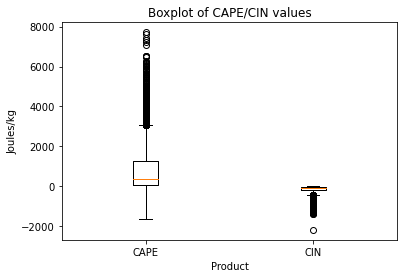

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
ax.boxplot(raob_cape_cin);
ax.set_xticklabels(['CAPE', 'CIN'])
ax.set_ylabel('Joules/kg'); ax.set_xlabel('Product')
ax.set_title('Boxplot of CAPE/CIN values')
plt.savefig('/home/stock/research/media/cape_cin_boxplot.pdf', dpi=300, bbox_inches='tight')

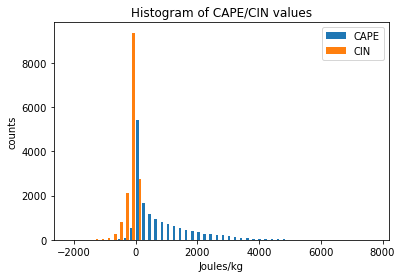

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
ax.hist(raob_cape_cin, bins=50, label=['CAPE', 'CIN']);
ax.legend()
ax.set_ylabel('counts'); ax.set_xlabel('Joules/kg')
ax.set_title('Histogram of CAPE/CIN values')
plt.savefig('/home/stock/research/media/cape_cin_histogram.pdf', dpi=300, bbox_inches='tight')

In [32]:
raob_cape_cin.shape, np.mean(raob_cape_cin, axis=0), np.mean(raob_cape_cin, axis=0)

((15445, 2),
 array([ 795.40190281, -131.658542  ]),
 array([ 795.40190281, -131.658542  ]))

# Fully Connected

In [82]:
r = np.concatenate([np.expand_dims(rap_parcel_profile, axis=-1), rap], axis=2)

Xtrain, Ttrain, Xtest, Ttest = ml.partition(r, raob_cape_cin, (0.8, 0.2), shuffle=True)

input_dims = [dl.PRESSURE, dl.TEMPERATURE, dl.DEWPOINT, -1]
Xt = Xtrain[:,:,input_dims].reshape(Xtrain.shape[0],-1)
Tt = Ttrain
Xe = Xtest[:,:,input_dims].reshape(Xtest.shape[0],-1)
Te = Ttest

Xt.shape, Tt.shape, Xe.shape, Te.shape

((64877, 1024), (64877, 2), (16219, 1024), (16219, 2))

In [83]:
nnet = nn.NeuralNetwork(Xt.shape[1], [16, 16, 16], Tt.shape[1], activation='relu',
                        batchnorm=True, dropout=True)

nnet.train(Xt, Tt, 100, 64, method='adam', learning_rate=0.0001, loss_f='MSE',
           verbose=True, validation=[Xe, Te])

epoch: 0, rmse 1.04285, val_rmse 0.78925
epoch: 20, rmse 0.70079, val_rmse 0.63737
epoch: 40, rmse 0.67700, val_rmse 0.64276
epoch: 60, rmse 0.66787, val_rmse 0.64949
epoch: 80, rmse 0.66049, val_rmse 0.63224
epoch: 99, rmse 0.66287, val_rmse 0.61639
finished!


NeuralNetwork(1024, [16, 16, 16], 2)
  Final objective value is 0.43939 in 320.6561 seconds.

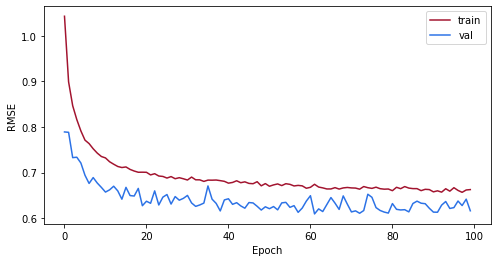

In [84]:
results.plot_loss(nnet)

RMSE: 261.08512504524083


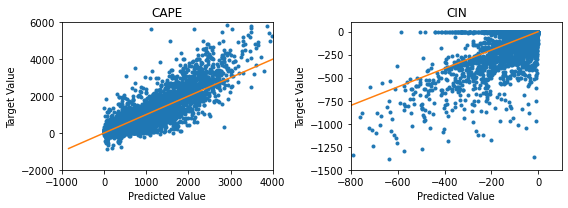

In [85]:
Y = nnet.use(Xe)
print('RMSE:', ml.rmse(Y, Te))
plot_results(Y, Te)

# Convolutional

In [206]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob_cape_cin, (0.8, 0.2), shuffle=True)

input_dims = [dl.PRESSURE, dl.TEMPERATURE, dl.DEWPOINT, dl.ALTITUDE]
Xtrain = Xtrain[:,:,input_dims]
Xtest = Xtest[:,:,input_dims]

Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((64877, 256, 4), (64877, 2), (16219, 256, 4), (16219, 2))

In [166]:
nnet = nn.ConvolutionalNeuralNetwork(Xtrain.shape[1:], [128, 256, 512], 
                                     [(5,1),(5,1),(5,1)], 
                                     Ttrain.shape[1], activation='relu', dropout=True)
nnet.train(Xtrain, Ttrain, 100, 64, method='adam', learning_rate=0.0001,
           verbose=True, validation=(Xtest, Ttest))

epoch: 0, rmse 1.03726, val_rmse 0.83719
epoch: 20, rmse 0.62444, val_rmse 0.65194
epoch: 40, rmse 0.59754, val_rmse 0.63557
epoch: 60, rmse 0.58404, val_rmse 0.66379
epoch: 80, rmse 0.56964, val_rmse 0.63951
epoch: 99, rmse 0.55863, val_rmse 0.65256
finished!


ConvolutionalNeuralNetwork((256, 4), [128, 256, 512], [(5, 1), (5, 1), (5, 1)], 2)
  Final objective value is 0.31207 in 786.8558 seconds.

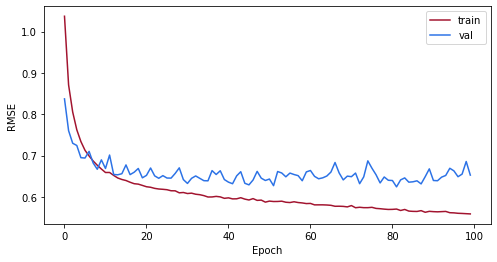

In [167]:
results.plot_loss(nnet)

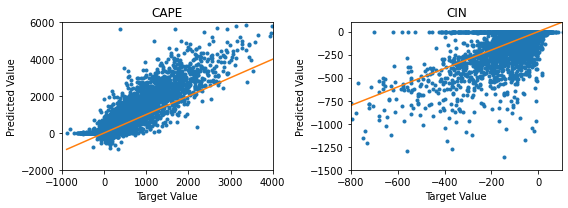

In [168]:
Y = nnet.use(Xtest)
print('RMSE:', ml.rmse(Y, Ttest))
plot_results(Y, Ttest)

# Benford's Curve

In [15]:
dydx = abs(np.diff(raob[:,:,dl.TEMPERATURE])/np.diff(raob[:,:,dl.ALTITUDE])).flatten()
raob_benfords = [int(('%e' % n).partition('.')[0]) for n in dydx]

dydx = abs(np.diff(rap[:,:,dl.TEMPERATURE])/np.diff(rap[:,:,dl.ALTITUDE])).flatten()
rap_benfords = [int(('%e' % n).partition('.')[0]) for n in dydx]

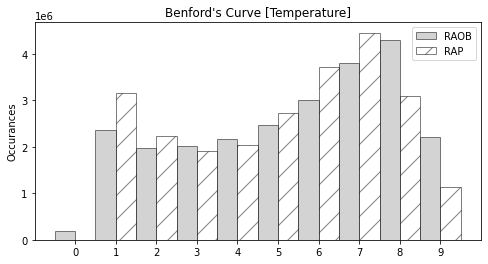

In [16]:
fig, ax = plt.subplots(figsize=(8,4))

width = 0.5

labels, counts = np.unique(raob_benfords, return_counts=True)
ax.bar(labels, counts, align='center', width=width,
       color='darkgrey', edgecolor='k', alpha=0.5, label='RAOB')

labels, counts = np.unique(rap_benfords, return_counts=True)
ax.bar(labels+width, counts, align='center', width=width,
       color='white', edgecolor='k', alpha=0.5, label='RAP', hatch='/')
plt.xticks(labels + width / 2, labels.astype(str).tolist());
ax.legend()

plt.ylabel('Occurances')
plt.title("Benford's Curve [Temperature]")

plt.savefig('/home/stock/research/media/benford_temperature', dpi=300)

In [17]:
dydx = abs(np.diff(raob[:,:,dl.DEWPOINT])/np.diff(raob[:,:,dl.ALTITUDE])).flatten()
raob_benfords = [int(('%e' % n).partition('.')[0]) for n in dydx]

dydx = abs(np.diff(rap[:,:,dl.DEWPOINT])/np.diff(rap[:,:,dl.ALTITUDE])).flatten()
rap_benfords = [int(('%e' % n).partition('.')[0]) for n in dydx]

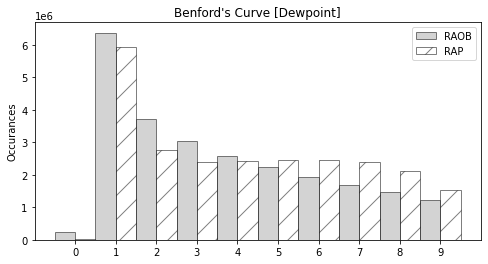

In [18]:
fig, ax = plt.subplots(figsize=(8,4))

width = 0.5

labels, counts = np.unique(raob_benfords, return_counts=True)
ax.bar(labels, counts, align='center', width=width,
       color='darkgrey', edgecolor='k', alpha=0.5, label='RAOB')

labels, counts = np.unique(rap_benfords, return_counts=True)
ax.bar(labels+width, counts, align='center', width=width,
       color='white', edgecolor='k', alpha=0.5, label='RAP', hatch='/')
plt.xticks(labels + width / 2, labels.astype(str).tolist());
ax.legend()

plt.ylabel('Occurances')
plt.title("Benford's Curve [Dewpoint]")

plt.savefig('/home/stock/research/media/benford_dewpoint', dpi=300)